# Обработка данных

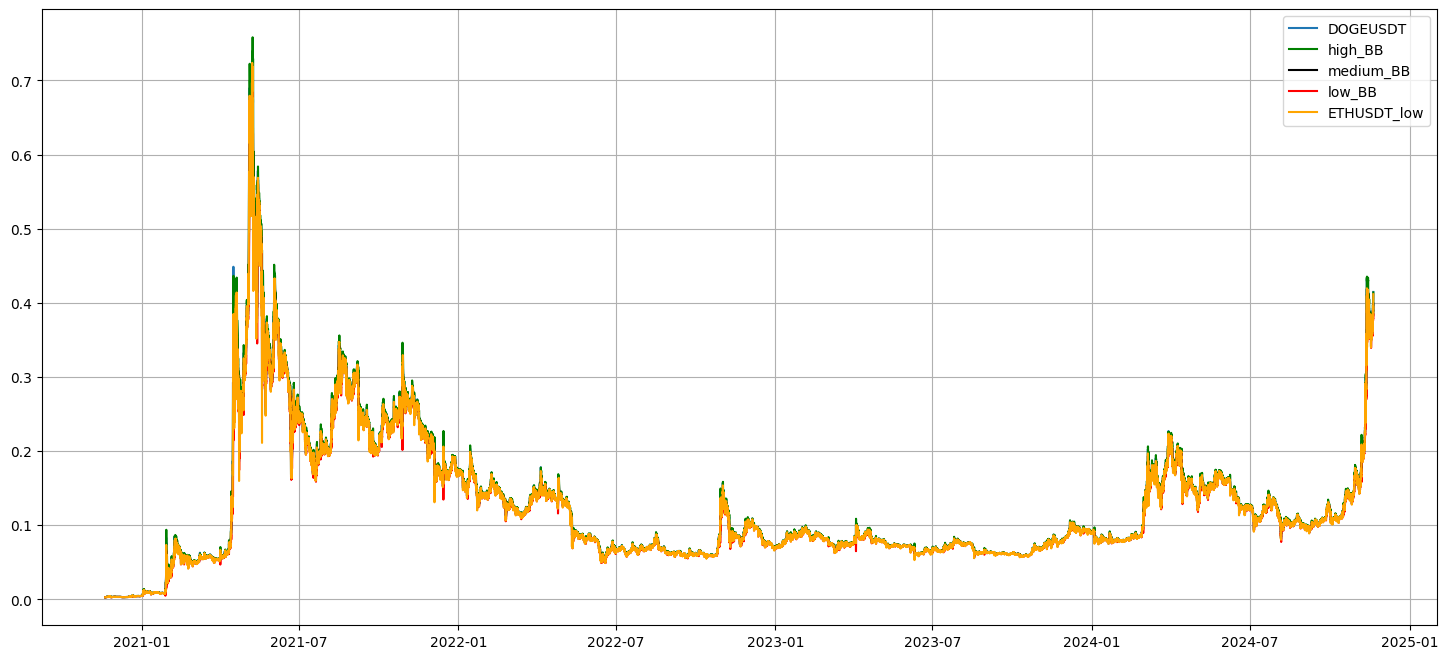

,Open time,Open,High,Low,Close,Volume,Normal_time_(utc3),high_BB,medium_BB,low_BB,ATR,RSI
0,2020-11-19 23:45:00,0.002904,0.002909,0.002904,0.002907,638047.0,2020-11-20 02:45:00,0.002924,0.002906,0.002888,0.000015,53.228325
1,2020-11-20 00:00:00,0.002910,0.002914,0.002901,0.002912,3455030.0,2020-11-20 03:00:00,0.002924,0.002906,0.002888,0.000015,56.008877
2,2020-11-20 00:15:00,0.002912,0.002918,0.002908,0.002914,2788365.0,2020-11-20 03:15:00,0.002925,0.002907,0.002889,0.000015,57.292302
3,2020-11-20 00:30:00,0.002914,0.002919,0.002907,0.002918,2142819.0,2020-11-20 03:30:00,0.002926,0.002907,0.002889,0.000015,59.399832
4,2020-11-20 00:45:00,0.002919,0.002919,0.002904,0.002909,1088140.0,2020-11-20 03:45:00,0.002925,0.002907,0.002889,0.000015,52.628452


In [1]:
# Импорт Фаила
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
# import mplfinance as mpf
import talib

df = pd.read_csv(r'DOGEUSDT_2020-11-19_2024-11-19_INTERVAL_15MINUTE.csv')
try:
    df['Normal_time_(utc3)'] = pd.to_datetime(df['Open time'], unit='ms')
except:
    df['Normal_time_(utc3)'] = pd.to_datetime(df['Open time'])
    
df['Normal_time_(utc3)'] += pd.Timedelta(hours=3)
### Предобработка
# Анализируем первые 200 элементов
# values, time = df['Close'].iloc[:200].values, df['Normal_time_(utc3)'].iloc[:200].values
values, time = df['Close'].iloc[:].values, df['Normal_time_(utc3)'].iloc[:].values
h,m,l = talib.BBANDS(values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)


fig = plt.figure()
fig.set_size_inches(18,8)
plt.plot(time, values)

plt.plot(time, h, c='green')
plt.plot(time, m, c='black')
plt.plot(time, l, c='red')
plt.plot(time, df['Low'].iloc[:], c='orange')
plt.legend(['DOGEUSDT', 'high_BB', 'medium_BB','low_BB', 'ETHUSDT_low'])
plt.grid(True)
plt.show()



df_work = df.copy()
df_work['high_BB'] = h
df_work['medium_BB'] = m
df_work['low_BB'] = l
df_work['ATR'] = talib.ATR(df_work['High'], df_work['Low'], df_work['Close'], 14)
# Добавляем RSI
df_work['RSI'] = talib.RSI(df_work['Close'], timeperiod=14)
df_work = df_work.drop(columns=df_work.columns[6:12], axis=1)
df_work = df_work.dropna()
df_work = df_work.reset_index().drop('index',axis=1)
df_work.head()


In [26]:
bag_for_results = []

# А1 - самая первая версия алгоритма

In [27]:

class Trade():
    def __init__(self, DEPOSIT: float, START_CAPITAL: float, STEP: float):
        '''
        :parm: DEPOSIT - Весь депозит на торговлю
        :parm: START_CAPITAL - Начальная сумма, с которой начнеться торговля
        :parm: STEP - Шаг, на который будет увеличиваться депозит начальный
        TOTAL_DOG - колличесвто догов
        TOTAL_AMOUNT - общее колличесвто потраченых денег
        AVG_PRICE_ENTER - средняя цена входа
        PERCENT_FOR_TP - процент TP. Вычисляеться в первой сделке. 
        TP - тейк профит, конечная цена 
        '''
        self.DEPOSIT = DEPOSIT
        self.START_CAPITAL = START_CAPITAL
        self.STEP = STEP
        #======================
        self.TOTAL_DOG = 0 
        self.TOTAL_AMOUNT = 0
        self.AVG_PRICE_ENTER = None
        self.PERCENT_FOR_TP = None
        self.TP = None
        self.number_of_transactions = 0
        #=====================
        self.open_first_trade_flag = False
        self.limit_price = None # Лимитка, ниже которй если цена опускаеться, то ставиться новая лимитка
        self.settings_dict = {}
        self.commission_rate = 0.001
        

    def count_TP(self, current_price: float, ATR: float):
        '''Здесь считаеться средня точка входа. Расчитываеться/ переносится TP. Рысчитываем новую лимитку на откуп
        :param: current_pricr - текущая цена отркытия оредра
        :param: ATR 
        '''
        self.TOTAL_AMOUNT = self.TOTAL_AMOUNT + (self.START_CAPITAL + self.STEP * self.number_of_transactions) # считаем общее колличесвто долларов
        self.TOTAL_DOG = self.TOTAL_DOG + ((self.START_CAPITAL + self.STEP * self.number_of_transactions) / current_price) # считаем общее колличесвто догов 

        self.AVG_PRICE_ENTER = self.TOTAL_AMOUNT / self.TOTAL_DOG
        self.TP = round(self.PERCENT_FOR_TP * self.AVG_PRICE_ENTER * ((1 + self.commission_rate) / (1 - self.commission_rate)), 5)

        # round(self.PERCENT_FOR_TP * self.AVG_PRICE_ENTER, 5)

        #================
        self.number_of_transactions += 1
        self.limit_price = current_price - (ATR * self.number_of_transactions)

        # self.limit_price = current_price - (ATR * (self.number_of_transactions + 1))
        # self.number_of_transactions = 1 + self.number_of_transactions

    def open_first_trade(self, current_price: float, TP_price: float):
        '''Здесь считаеться процент TP. Процент сохраняеться для всех послед сделок
        :param: current_pricr - текущая цена отркытия оредра
        :param: TP_price - это врехняя граница BB
        '''
   
        self.PERCENT_FOR_TP = TP_price / current_price
        self.open_first_trade_flag = True



    def open_long_oredr(self, row: pd.Series):
        '''Проверяем условия на вход в позицию'''
        if self.limit_price == None:
            low_price_to_comper = row['low_BB']
        else:
            low_price_to_comper = self.limit_price

        if row['Low'] < low_price_to_comper:
            if not self.open_first_trade_flag:
                self.open_first_trade(current_price=row['Low'], TP_price=row['high_BB']) # высчитываем процент
            self.count_TP(current_price=row['Low'], ATR=row['ATR'])
            self.fill_setting_dict(row=row)


    def check_TP(self, row: pd.Series):
        if self.TP != None:
            if row['High'] >= self.TP:
                # Реинициализация класса при достижении TP
                exit_value = self.TOTAL_DOG * self.TP * (1 - self.commission_rate)
                profit = exit_value - self.TOTAL_AMOUNT
                self.settings_dict.update({
                    'index_finish': row.name,
                    'time_continius': self.settings_dict.get('time_continius', []) + [row['Normal_time_(utc3)']],
                    'prices': np.array(self.settings_dict.get('prices', [])),
                    'time_finish': row['Normal_time_(utc3)'],
                    'TP': self.TP,
                    "profit_sum": profit,
                    'position money': self.TOTAL_AMOUNT,
                    "Total_Deposit": self.DEPOSIT
                })
                new_deposit = self.DEPOSIT + profit
                START_CAPITAL = new_deposit * 0.034473684210526316
                step = new_deposit * 0.010263157894736842
                # print(new_deposit, START_CAPITAL, step)

                RESULT.append(self.settings_dict.copy())
                self.__init__(new_deposit, START_CAPITAL, step)
    


    def fill_setting_dict(self, row: pd.Series):
        if len(self.settings_dict) == 0:
             self.settings_dict.update({
                'prices': [row['low_BB']],
                'side': 'Buy',
                'time_start': row['Normal_time_(utc3)'],
                'indexes_start': row.name,
                'time_continius': [row['Normal_time_(utc3)']],
                'next_price': self.limit_price,
                'TP': self.TP,
                # 'ATR': [row['ATR']],
            })
        else:
            self.settings_dict['prices'].append(self.limit_price)
            self.settings_dict['TP'] = self.TP
            self.settings_dict['time_continius'].append(row['Normal_time_(utc3)'])
            # self.settings_dict['ATR'].append(row['ATR'] * coefficient)
                

            
RESULT = []

          

trade = Trade(DEPOSIT=3800, START_CAPITAL=100, STEP=50)

for index, row in df_work.iterrows():
    trade.open_long_oredr(row)  # Проверяем, нужно ли войти в сделку
    trade.check_TP(row)  # Проверяем, достигли ли TP
   
df_result = pd.DataFrame(RESULT)
df_result['Deals'] = df_result['prices'].apply(lambda x: len(x))
df_result['durration'] = (df_result['time_finish'] - df_result['time_start']).copy()
bag_for_results.append((df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max()))
df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max() 
      

(25963.152200689176,
 Timedelta('484 days 05:00:00'),
 Timedelta('4 days 13:14:30'),
 (300, 14),
 86.54384066896392,
 10)

# А2 -  улучшенный алгоритм. Примененн новый подход к распределению капитала

In [28]:
RESULT = []
class Trade_2():
    def __init__(self, DEPOSIT: float, START_CAPITAL: float, pos_step: float, neg_step: float, inc_step: float):
        self.DEPOSIT = DEPOSIT
        self.START_CAPITAL = START_CAPITAL
        self.pos_step = pos_step
        self.neg_step = neg_step
        self.inc_step = inc_step

        self.TOTAL_DOG = 0
        self.TOTAL_AMOUNT = 0
        self.AVG_PRICE_ENTER = None
        self.PERCENT_FOR_TP_1 = None
        self.PERCENT_FOR_TP_2 = None
        self.TP1 = None
        self.TP2 = None
        self.number_of_transactions = 0

        self.open_first_trade_flag = False
        self.limit_price = None
        self.settings_dict = {}
        self.Ai_indicator = False
        self.Ai_indicator_1H = False

        self.koef_START_CAPITAL = START_CAPITAL / DEPOSIT
        self.koef_pos_step = pos_step / DEPOSIT
        self.koef_neg_step = -neg_step / DEPOSIT
        self.koef_inc_step = inc_step / DEPOSIT
        self.commission_rate = 0.001

        self.recompute_investment_scheme()

    def recompute_investment_scheme(self):
        raw_scheme = []
        for n in range(1, 12):
            if n == 1:
                raw_amt = self.START_CAPITAL
            elif n == 2:
                raw_amt = self.START_CAPITAL + self.pos_step
            elif 3 <= n <= 6:
                raw_amt = self.START_CAPITAL + self.pos_step + (n - 2) * self.neg_step
            elif 7 <= n <= 11:
                raw_amt = (self.START_CAPITAL + self.pos_step + 4 * self.neg_step) + (n - 6) * self.inc_step
            raw_scheme.append(raw_amt)

        total_raw_cost = sum([amt * (1 + self.commission_rate) for amt in raw_scheme])
        scale = min(1.0, self.DEPOSIT / total_raw_cost)

        self.investment_scheme = [amt * scale for amt in raw_scheme]
        self.inc_step_scaled = self.inc_step * scale  # для сделок > 11

    def adaptive_investment(self, n: int) -> float:
        if hasattr(self, 'investment_scheme') and 1 <= n <= 11:
            return self.investment_scheme[n - 1]
        else:
            return self.investment_scheme[-1] + (n - 11) * self.inc_step_scaled

    def count_TP(self, current_price: float, ATR: float):
        current_investment = self.adaptive_investment(self.number_of_transactions + 1)
        open_cost = current_investment * (1 + self.commission_rate)

        if self.TOTAL_AMOUNT + open_cost > self.DEPOSIT:
            return  # Недостаточно средств — сделку не открываем

        self.TOTAL_AMOUNT += open_cost
        self.TOTAL_DOG += current_investment / current_price
        self.AVG_PRICE_ENTER = self.TOTAL_AMOUNT / self.TOTAL_DOG

        if self.PERCENT_FOR_TP_1 is not None:
            self.TP1 = round(self.PERCENT_FOR_TP_1 * self.AVG_PRICE_ENTER * ((1 + self.commission_rate) / (1 - self.commission_rate)), 5)

        if self.PERCENT_FOR_TP_2 is not None:
            self.TP2 = round(self.PERCENT_FOR_TP_2 * self.AVG_PRICE_ENTER * ((1 + self.commission_rate) / (1 - self.commission_rate)), 5)

        self.number_of_transactions += 1

        delitel = 1

        self.limit_price = round(current_price - (ATR * self.number_of_transactions / delitel), 5)

    def open_first_trade(self, current_price: float, TP_price_medium: float, TP_price_high: float):
        '''
        Устанавливает коэффициенты для расчёта TP по первой сделке.
        '''
        self.PERCENT_FOR_TP_1 = TP_price_medium / current_price
        self.PERCENT_FOR_TP_2 = TP_price_high / current_price
        self.open_first_trade_flag = True

    def open_long_oredr(self, row: pd.Series):
        '''
        Проверяет условия входа в позицию и открывает сделку, если они соблюдены.
        '''
        if self.limit_price is None:
            low_price_to_comper = row['low_BB']
        else:
            low_price_to_comper = self.limit_price

        if low_price_to_comper >= row['Low']:
            if not self.open_first_trade_flag:
                self.open_first_trade(current_price=low_price_to_comper,
                                      TP_price_medium=row['medium_BB'],
                                      TP_price_high=row['high_BB'])
            self.fill_setting_dict(row=row)
            self.count_TP(current_price=low_price_to_comper, ATR=row['ATR'])

    def check_TP(self, row: pd.Series):
        '''
        Проверяет достижение TP и, если условие выполнено, закрывает сделку и обновляет параметры.
        '''
        Flag = True
        if self.TP1 is not None:
            # Проверка: если сделка открыта в той же свече, то она должна быть бычьей
            if self.settings_dict.get('time_start') == row['Normal_time_(utc3)']:
                if not (row['Close'] > row['Open']):  # Свеча не растущая
                    Flag = False

            if Flag:
                if (row['High'] >= self.TP1 and self.number_of_transactions <= 8) or \
                   (row['High'] >= self.TP2 and self.number_of_transactions > 8):
                    TP = self.TP1 if self.number_of_transactions <= 8 else self.TP2
                    # Учёт комиссии при закрытии сделки
                    exit_value = self.TOTAL_DOG * TP * (1 - self.commission_rate)
                    profit = exit_value - self.TOTAL_AMOUNT
                    self.settings_dict.update({
                        'index_finish': row.name,
                        'time_continius': self.settings_dict.get('time_continius', []) + [row['Normal_time_(utc3)']],
                        'prices': self.settings_dict.get('prices', []),
                        'time_finish': row['Normal_time_(utc3)'],
                        'TP': TP,
                        "profit_sum": profit,
                        'position money': self.TOTAL_AMOUNT,
                        "Total_Deposit": self.DEPOSIT
                    })
                    RESULT.append(self.settings_dict.copy())

                    new_deposit = self.DEPOSIT + profit
                    # Переинициализация с сохранением параметров адаптивной шкалы
                    START_CAPITAL = new_deposit * self.koef_START_CAPITAL
                    pos_step = new_deposit * self.koef_pos_step
                    neg_step = new_deposit * self.koef_neg_step
                    inc_step = new_deposit * self.koef_inc_step
                    self.__init__(new_deposit, START_CAPITAL, pos_step, neg_step, inc_step)

    def fill_setting_dict(self, row: pd.Series):
        '''
        Заполняет словарь параметров торгового цикла.
        '''
        if len(self.settings_dict) == 0:
            self.settings_dict.update({
                'prices': [row['low_BB']],
                'side': 'Buy',
                'time_start': row['Normal_time_(utc3)'],
                'indexes_start': row.name,
                'time_continius': [row['Normal_time_(utc3)']],
                'next_price': self.limit_price,
            })
        else:
            self.settings_dict['prices'].append(self.limit_price)
            self.settings_dict['time_continius'].append(row['Normal_time_(utc3)'])


DEPOSIT = 3850
START_CAPITAL = 200
pos_step = 100
neg_step = -10
inc_step = 50
trade = Trade_2(DEPOSIT=DEPOSIT, START_CAPITAL=START_CAPITAL, pos_step=pos_step, neg_step=neg_step, inc_step=inc_step)

for index, row in df_work.iterrows():
    trade.open_long_oredr(row)  
    trade.check_TP(row)        

df_result = pd.DataFrame(RESULT)
df_result['Deals'] = df_result['prices'].apply(lambda x: len(x))
df_result['durration'] = (df_result['time_finish'] - df_result['time_start']).copy()
bag_for_results.append((df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max()))
df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max() 

(33322.461508542445,
 Timedelta('189 days 13:15:00'),
 Timedelta('1 days 12:29:45.626535626'),
 (814, 14),
 40.93668489992929,
 10)

# А3 - Прямая интеграция модели с алгоритмом

In [6]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.load_model("Model1_trend_flet.cbm")

def model_predict(index: int, df_work: pd.DataFrame) -> int:
    """
    Находит необходимые данные в DataFrame для заданного индекса и возврщает данные в читаемом для моделе виде/
    Возвращает число. 0 флет, 1 тренд"""
    
    start_index = index-300 if index-300 >= 0 else 0
    data = df_work.iloc[start_index:index + 1].copy()

    last_volume = data['Volume'].iloc[-1]
    avg_volume = data['Volume'].mean()

    Close_price = data['Close'].iloc[-1]
    low_BB = data['low_BB'].iloc[-1]

    # return data['Volume'].mean(), data['Volume'].iloc[-1], data['RSI'].iloc[-1], data['Close'].iloc[-1],  data['low_BB'].iloc[-1]
    close_hier_low_BB = (data["Close"].iloc[-1] > data["low_BB"].iloc[-1]).astype(int)
    volume_diff_pct = ((last_volume - avg_volume) / last_volume * 100).round(2)
    price_diff_pct = ((Close_price - low_BB) / Close_price * 100).round(2)

    data_list =  [[data['RSI'].iloc[-1], close_hier_low_BB, volume_diff_pct, price_diff_pct]]
    return model.predict(data_list)[0]

In [29]:
RESULT = []

class Trade_3():
    def __init__(self, DEPOSIT: float, START_CAPITAL: float, pos_step: float, neg_step: float, inc_step: float):
        self.DEPOSIT = DEPOSIT
        self.START_CAPITAL = START_CAPITAL
        self.pos_step = pos_step
        self.neg_step = neg_step
        self.inc_step = inc_step

        self.TOTAL_DOG = 0
        self.TOTAL_AMOUNT = 0
        self.AVG_PRICE_ENTER = None
        self.PERCENT_FOR_TP_1 = None
        self.PERCENT_FOR_TP_2 = None
        self.TP1 = None
        self.TP2 = None
        self.number_of_transactions = 0

        self.open_first_trade_flag = False
        self.limit_price = None
        self.settings_dict = {}
        self.Ai_indicator = False
        self.Ai_indicator_1H = False

        self.koef_START_CAPITAL = START_CAPITAL / DEPOSIT
        self.koef_pos_step = pos_step / DEPOSIT
        self.koef_neg_step = -neg_step / DEPOSIT
        self.koef_inc_step = inc_step / DEPOSIT
        self.commission_rate = 0.001

        self.recompute_investment_scheme()

    def recompute_investment_scheme(self):
        raw_scheme = []
        for n in range(1, 12):
            if n == 1:
                raw_amt = self.START_CAPITAL
            elif n == 2:
                raw_amt = self.START_CAPITAL + self.pos_step
            elif 3 <= n <= 6:
                raw_amt = self.START_CAPITAL + self.pos_step + (n - 2) * self.neg_step
            elif 7 <= n <= 11:
                raw_amt = (self.START_CAPITAL + self.pos_step + 4 * self.neg_step) + (n - 6) * self.inc_step
            raw_scheme.append(raw_amt)

        total_raw_cost = sum([amt * (1 + self.commission_rate) for amt in raw_scheme])
        scale = min(1.0, self.DEPOSIT / total_raw_cost)

        self.investment_scheme = [amt * scale for amt in raw_scheme]
        self.inc_step_scaled = self.inc_step * scale  # для сделок > 11

    def adaptive_investment(self, n: int) -> float:
        if hasattr(self, 'investment_scheme') and 1 <= n <= 11:
            return self.investment_scheme[n - 1]
        else:
            return self.investment_scheme[-1] + (n - 11) * self.inc_step_scaled

    def count_TP(self, current_price: float, ATR: float):
        current_investment = self.adaptive_investment(self.number_of_transactions + 1)
        open_cost = current_investment * (1 + self.commission_rate)

        if self.TOTAL_AMOUNT + open_cost > self.DEPOSIT:
            return  # Недостаточно средств — сделку не открываем

        self.TOTAL_AMOUNT += open_cost
        self.TOTAL_DOG += current_investment / current_price
        self.AVG_PRICE_ENTER = self.TOTAL_AMOUNT / self.TOTAL_DOG

        if self.PERCENT_FOR_TP_1 is not None:
            self.TP1 = round(self.PERCENT_FOR_TP_1 * self.AVG_PRICE_ENTER * ((1 + self.commission_rate) / (1 - self.commission_rate)), 5)

        if self.PERCENT_FOR_TP_2 is not None:
            self.TP2 = round(self.PERCENT_FOR_TP_2 * self.AVG_PRICE_ENTER * ((1 + self.commission_rate) / (1 - self.commission_rate)), 5)

        self.number_of_transactions += 1

        delitel = 1
        self.limit_price = round(current_price - (ATR * self.number_of_transactions / delitel), 5)

    def open_first_trade(self, current_price: float, TP_price_medium: float, TP_price_high: float):
        self.PERCENT_FOR_TP_1 = TP_price_medium / current_price
        self.PERCENT_FOR_TP_2 = TP_price_high / current_price
        self.open_first_trade_flag = True

    def open_long_oredr(self, row: pd.Series):
        if self.limit_price is None:
            low_price_to_comper = row['low_BB'] * 0.99999
        else:
            low_price_to_comper = self.limit_price

        def base_old_algorythim():
            if not self.open_first_trade_flag:
                self.open_first_trade(current_price=low_price_to_comper,
                                      TP_price_medium=row['medium_BB'],
                                      TP_price_high=row['high_BB'])
            self.fill_setting_dict(row=row)
            self.count_TP(current_price=low_price_to_comper, ATR=row['ATR'])

        if low_price_to_comper >= row['Low']:
            if self.number_of_transactions <= 3:
                base_old_algorythim()
            else:
                trend = model_predict(row.name, df_work)
                # trend = 0
                if trend == 0 and not self.Ai_indicator:
                    base_old_algorythim()
                elif trend == 0 and self.Ai_indicator:
            
                    self.Ai_indicator = False
                    old_price = self.limit_price
                    atr = row['ATR']
                    new_price = row['Open']  # можно добавить -atr * x

                    if new_price >= row['Low'] and new_price <= self.limit_price:
                        self.limit_price = new_price
                        self.fill_setting_dict(row=row, AI=(self.number_of_transactions, old_price, self.limit_price))
                        self.count_TP(current_price=self.limit_price, ATR=atr)
                    else:
                        base_old_algorythim()
                elif trend == 1:
                    self.Ai_indicator = True

    def check_TP(self, row: pd.Series):
        Flag = True
        if self.TP1 is not None:
            if self.settings_dict.get('time_start') == row['Normal_time_(utc3)']:
                if not (row['Close'] > row['Open']):
                    Flag = False
            if Flag:
                if (row['High'] >= self.TP1 and self.number_of_transactions <= 8) or \
                   (row['High'] >= self.TP2 and self.number_of_transactions > 8):
                    TP = self.TP1 if self.number_of_transactions <= 8 else self.TP2
                    exit_value = self.TOTAL_DOG * TP * (1 - self.commission_rate)
                    profit = exit_value - self.TOTAL_AMOUNT
                    self.settings_dict.update({
                        'index_finish': row.name,
                        'time_continius': self.settings_dict.get('time_continius', []) + [row['Normal_time_(utc3)']],
                        'prices': self.settings_dict.get('prices', []),
                        'time_finish': row['Normal_time_(utc3)'],
                        'TP': TP,
                        "profit_sum": profit,
                        'position money': self.TOTAL_AMOUNT,
                        "Total_Deposit": self.DEPOSIT
                    })
                    RESULT.append(self.settings_dict.copy())

                    new_deposit = self.DEPOSIT + profit
                    START_CAPITAL = new_deposit * self.koef_START_CAPITAL
                    pos_step = new_deposit * self.koef_pos_step
                    neg_step = new_deposit * self.koef_neg_step
                    inc_step = new_deposit * self.koef_inc_step
                    self.__init__(new_deposit, START_CAPITAL, pos_step, neg_step, inc_step)

    def fill_setting_dict(self, row: pd.Series, AI: list = None):
        if len(self.settings_dict) == 0:
            self.settings_dict.update({
                'prices': [row['low_BB']],
                'side': 'Buy',
                'time_start': row['Normal_time_(utc3)'],
                'indexes_start': row.name,
                'time_continius': [row['Normal_time_(utc3)']],
                'indexes': [row.name],
                'AI': []
            })
        else:
            self.settings_dict['prices'].append(self.limit_price)
            self.settings_dict['time_continius'].append(row['Normal_time_(utc3)'])
            self.settings_dict['indexes'].append(row.name)
            if AI:
                self.settings_dict['AI'].append(AI)




DEPOSIT = 3850
START_CAPITAL = 0.05194805194805195 * DEPOSIT
pos_step = 0.025974025974025976 * DEPOSIT
neg_step = -0.0025974025974025974 * DEPOSIT
inc_step = 0.012987012987012988 * DEPOSIT

trade = Trade_3(DEPOSIT=DEPOSIT, START_CAPITAL=START_CAPITAL, pos_step=pos_step, neg_step=neg_step, inc_step=inc_step)


for index, row in df_work.iterrows():
    trade.open_long_oredr(row)  
    trade.check_TP(row)  


df_result = pd.DataFrame(RESULT)
df_result['Deals'] = df_result['prices'].apply(lambda x: len(x))
df_result['durration'] = (df_result['time_finish'] - df_result['time_start']).copy()
bag_for_results.append((df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max()))
df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max() 


(12647.124377912227,
 Timedelta('846 days 09:15:00'),
 Timedelta('2 days 19:25:25.423728813'),
 (472, 15),
 26.794755037949635,
 11)

# А4 - улучшенный алгритм с применением ML

In [30]:
RESULT = []
class Trade_4():
    def __init__(self, DEPOSIT: float, START_CAPITAL: float, pos_step: float, neg_step: float, inc_step: float):
        self.DEPOSIT = DEPOSIT
        self.START_CAPITAL = START_CAPITAL
        self.pos_step = pos_step
        self.neg_step = neg_step
        self.inc_step = inc_step

        self.TOTAL_DOG = 0
        self.TOTAL_AMOUNT = 0
        self.AVG_PRICE_ENTER = None
        self.PERCENT_FOR_TP_1 = None
        self.PERCENT_FOR_TP_2 = None
        self.TP1 = None
        self.TP2 = None
        self.number_of_transactions = 0

        self.open_first_trade_flag = False
        self.limit_price = None
        self.settings_dict = {}
        self.Ai_indicator = False
        self.Ai_indicator_1H = False

        self.koef_START_CAPITAL = START_CAPITAL / DEPOSIT
        self.koef_pos_step = pos_step / DEPOSIT
        self.koef_neg_step = -neg_step / DEPOSIT
        self.koef_inc_step = inc_step / DEPOSIT
        self.commission_rate = 0.001

        self.recompute_investment_scheme()

    def recompute_investment_scheme(self):
        raw_scheme = []
        for n in range(1, 12):
            if n == 1:
                raw_amt = self.START_CAPITAL
            elif n == 2:
                raw_amt = self.START_CAPITAL + self.pos_step
            elif 3 <= n <= 6:
                raw_amt = self.START_CAPITAL + self.pos_step + (n - 2) * self.neg_step
            elif 7 <= n <= 11:
                raw_amt = (self.START_CAPITAL + self.pos_step + 4 * self.neg_step) + (n - 6) * self.inc_step
            raw_scheme.append(raw_amt)

        total_raw_cost = sum([amt * (1 + self.commission_rate) for amt in raw_scheme])
        scale = min(1.0, self.DEPOSIT / total_raw_cost)

        self.investment_scheme = [amt * scale for amt in raw_scheme]
        self.inc_step_scaled = self.inc_step * scale  # для сделок > 11

    def adaptive_investment(self, n: int) -> float:
        if hasattr(self, 'investment_scheme') and 1 <= n <= 11:
            return self.investment_scheme[n - 1]
        else:
            return self.investment_scheme[-1] + (n - 11) * self.inc_step_scaled

    def count_TP(self, current_price: float, ATR: float):
        current_investment = self.adaptive_investment(self.number_of_transactions + 1)
        open_cost = current_investment * (1 + self.commission_rate)

        if self.TOTAL_AMOUNT + open_cost > self.DEPOSIT:
            return  # Недостаточно средств — сделку не открываем

        self.TOTAL_AMOUNT += open_cost
        self.TOTAL_DOG += current_investment / current_price
        self.AVG_PRICE_ENTER = self.TOTAL_AMOUNT / self.TOTAL_DOG

        if self.PERCENT_FOR_TP_1 is not None:
            self.TP1 = round(self.PERCENT_FOR_TP_1 * self.AVG_PRICE_ENTER * ((1 + self.commission_rate) / (1 - self.commission_rate)), 5)

        if self.PERCENT_FOR_TP_2 is not None:
            self.TP2 = round(self.PERCENT_FOR_TP_2 * self.AVG_PRICE_ENTER * ((1 + self.commission_rate) / (1 - self.commission_rate)), 5)

        self.number_of_transactions += 1

        delitel = 1
        if self.number_of_transactions >= 4:
            delitel = 1.66
        if self.number_of_transactions >= 6:
            delitel = 1.6
        if self.number_of_transactions >= 9:
            delitel = 1.15

        self.limit_price = round(current_price - (ATR * self.number_of_transactions / delitel), 5)
        # self.limit_price = current_price - (ATR * self.number_of_transactions)

    def open_first_trade(self, current_price: float, TP_price_medium: float, TP_price_high: float):
        self.PERCENT_FOR_TP_1 = TP_price_medium / current_price
        self.PERCENT_FOR_TP_2 = TP_price_high / current_price
        self.open_first_trade_flag = True

    def open_long_oredr(self, row: pd.Series):
        if self.limit_price is None:
            low_price_to_comper = row['low_BB'] * 0.99999
        else:
            low_price_to_comper = self.limit_price

        def base_old_algorythim():
            if not self.open_first_trade_flag:
                self.open_first_trade(current_price=low_price_to_comper,
                                      TP_price_medium=row['medium_BB'],
                                      TP_price_high=row['high_BB'])
            self.fill_setting_dict(row=row)
            self.count_TP(current_price=low_price_to_comper, ATR=row['ATR'])

        if low_price_to_comper >= row['Low']:
            if self.number_of_transactions <= 3:
                base_old_algorythim()
            else:
                trend = model_predict(row.name, df_work)
                # trend = 0
                if trend == 0 and not self.Ai_indicator:
                    base_old_algorythim()
                elif trend == 0 and self.Ai_indicator:
                    # if model_predict(index_1h, df_work_1H) == 0:
                    self.Ai_indicator = False
                    old_price = self.limit_price
                    atr = row['ATR']
                    new_price = row['Open']  # можно добавить -atr * x

                    if new_price >= row['Low'] and new_price <= self.limit_price:
                        self.limit_price = new_price
                        self.fill_setting_dict(row=row, AI=(self.number_of_transactions, old_price, self.limit_price))
                        self.count_TP(current_price=self.limit_price, ATR=atr)
                    else:
                        base_old_algorythim()
                elif trend == 1:
                    self.Ai_indicator = True

    def check_TP(self, row: pd.Series):
        Flag = True
        if self.TP1 is not None:
            if self.settings_dict.get('time_start') == row['Normal_time_(utc3)']:
                if not (row['Close'] > row['Open']):
                    Flag = False
            if Flag:
                if (row['High'] >= self.TP1 and self.number_of_transactions <= 8) or \
                   (row['High'] >= self.TP2 and self.number_of_transactions > 8):
                    TP = self.TP1 if self.number_of_transactions <= 8 else self.TP2
                    exit_value = self.TOTAL_DOG * TP * (1 - self.commission_rate)
                    profit = exit_value - self.TOTAL_AMOUNT
                    self.settings_dict.update({
                        'index_finish': row.name,
                        'time_continius': self.settings_dict.get('time_continius', []) + [row['Normal_time_(utc3)']],
                        'prices': self.settings_dict.get('prices', []),
                        'time_finish': row['Normal_time_(utc3)'],
                        'TP': TP,
                        "profit_sum": profit,
                        'position money': self.TOTAL_AMOUNT,
                        "Total_Deposit": self.DEPOSIT
                    })
                    RESULT.append(self.settings_dict.copy())

                    new_deposit = self.DEPOSIT + profit
                    START_CAPITAL = new_deposit * self.koef_START_CAPITAL
                    pos_step = new_deposit * self.koef_pos_step
                    neg_step = new_deposit * self.koef_neg_step
                    inc_step = new_deposit * self.koef_inc_step
                    self.__init__(new_deposit, START_CAPITAL, pos_step, neg_step, inc_step)

    def fill_setting_dict(self, row: pd.Series, AI: list = None):
        if len(self.settings_dict) == 0:
            self.settings_dict.update({
                'prices': [row['low_BB']],
                'side': 'Buy',
                'time_start': row['Normal_time_(utc3)'],
                'indexes_start': row.name,
                'time_continius': [row['Normal_time_(utc3)']],
                'indexes': [row.name],
                'AI': []
            })
        else:
            self.settings_dict['prices'].append(self.limit_price)
            self.settings_dict['time_continius'].append(row['Normal_time_(utc3)'])
            self.settings_dict['indexes'].append(row.name)
            if AI:
                self.settings_dict['AI'].append(AI)




DEPOSIT = 3850
START_CAPITAL = 0.05194805194805195 * DEPOSIT
pos_step = 0.025974025974025976 * DEPOSIT
neg_step = -0.0025974025974025974 * DEPOSIT
inc_step = 0.012987012987012988 * DEPOSIT

trade = Trade_4(DEPOSIT=DEPOSIT, START_CAPITAL=START_CAPITAL, pos_step=pos_step, neg_step=neg_step, inc_step=inc_step)



for index, row in df_work.iterrows():
    trade.open_long_oredr(row)  
    trade.check_TP(row)  


df_result = pd.DataFrame(RESULT)
df_result['Deals'] = df_result['prices'].apply(lambda x: len(x))
df_result['durration'] = (df_result['time_finish'] - df_result['time_start']).copy()
bag_for_results.append((df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max()))
df_result['profit_sum'].sum(),  df_result["durration"].max(), df_result["durration"].mean(), df_result.shape, df_result['profit_sum'].mean(), df_result['Deals'].max() 


(44630.1305532391,
 Timedelta('185 days 20:45:00'),
 Timedelta('1 days 07:15:33.045356371'),
 (926, 15),
 48.196685262677214,
 11)

# Таблица с результатми 

In [46]:
df_final_tabel = pd.DataFrame(bag_for_results, columns=['Чистая прибыль $', 'Максимальное время в позиции', 'Среднее время в позиции', 'Количество сделок', 'Средняя прибыль с каждой сделки', 'Максимальное количество открытых позиций.'])
df_final_tabel.index = ['A 1', 'A 2', 'A 3', 'A 4']  
df_final_tabel['Чистая прибыль $'] = df_final_tabel['Чистая прибыль $'].round(2)
df_final_tabel

,Чистая прибыль $,Максимальное время в позиции,Среднее время в позиции,Количество сделок,Средняя прибыль с каждой сделки,Максимальное количество открытых позиций.
A 1,25963.15,484 days 05:00:00,4 days 13:14:30,"(300, 14)",86.543841,10
A 2,33322.46,189 days 13:15:00,1 days 12:29:45.626535626,"(814, 14)",40.936685,10
A 3,12647.12,846 days 09:15:00,2 days 19:25:25.423728813,"(472, 15)",26.794755,11
A 4,44630.13,185 days 20:45:00,1 days 07:15:33.045356371,"(926, 15)",48.196685,11
